In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm
import random
import re
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b3

# Reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = False

# Helper
def get_series_number(img_name):
    match = re.search(r'IM-(\d+)-', img_name)
    return match.group(1) if match else None

# Attention Block
class AttentionBlock(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm = nn.LayerNorm(dim)
        self.linear = nn.Linear(dim, dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        attn_output, _ = self.attn(x, x, x)
        x = self.norm(attn_output + x)
        return self.linear(x.squeeze(1))

# Dataset
class FetalMRIDataset(Dataset):
    def __init__(self, root_dir, labels_file, transform=None, tta=False):
        self.root_dir = root_dir
        self.labels_df = pd.read_excel(labels_file)
        self.transform = transform
        self.tta = tta
        self.data = []

        for _, row in self.labels_df.iterrows():
            pid, ga = str(row['patient_id']), row['ga_days']
            ax, cor, sag = str(row['ax_series']).zfill(4), str(row['cor_series']).zfill(4), str(row['sag_series']).zfill(4)
            folder = os.path.join(self.root_dir, pid)
            if not os.path.exists(folder): continue

            views = {'axial': [], 'coronal': [], 'sagittal': []}
            for img_file in os.listdir(folder):
                if img_file.endswith(".jpg"):
                    series = get_series_number(img_file)
                    path = os.path.join(folder, img_file)
                    if series == ax: views['axial'].append(path)
                    elif series == cor: views['coronal'].append(path)
                    elif series == sag: views['sagittal'].append(path)

            max_len = max(len(v) for v in views.values())
            for axis in views:
                if len(views[axis]) < max_len:
                    views[axis] = random.choices(views[axis], k=max_len)
                else:
                    views[axis] = random.sample(views[axis], k=max_len)

            for p in views['axial'] + views['coronal'] + views['sagittal']:
                self.data.append((p, ga))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Paths
data_root = "/kaggle/input/fetal-brain/images"
label_path = "/kaggle/input/fetal-brain/images/labels.xlsx"

# Load Data
full_dataset = FetalMRIDataset(data_root, label_path, transform=train_transform)
train_idx, val_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.2, random_state=42)
train_set = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = FetalMRIDataset(data_root, label_path, transform=val_transform, tta=True)
val_set = torch.utils.data.Subset(val_dataset, val_idx)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Model
class GARegressor(nn.Module):
    def __init__(self):
        super().__init__()
        base = efficientnet_b3(pretrained=True)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        dim = base.classifier[1].in_features
        self.attn = AttentionBlock(dim)
        self.regressor = nn.Sequential(nn.ReLU(), nn.Dropout(0.3), nn.Linear(dim, 1))

    def forward(self, x):
        x = self.features(x.contiguous())
        x = self.pool(x)
        x = self.flatten(x)
        x = self.attn(x)
        return self.regressor(x).squeeze(1)

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GARegressor().to(device)

# Multi-GPU Support
if torch.cuda.device_count() > 1:
    print(f"🖥 Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training Loop
best_mae, best_r2 = float('inf'), -float('inf')
patience, no_improve = 5, 0

for epoch in range(1, 101):
    model.train()
    y_train_true, y_train_pred = [], []
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        y_train_true.extend(labels.cpu().numpy())
        y_train_pred.extend(outputs.detach().cpu().numpy())

    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    train_r2 = r2_score(y_train_true, y_train_pred)

    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            preds = [model(images).cpu().numpy() for _ in range(3)]  # TTA
            mean_preds = np.mean(preds, axis=0)
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(mean_preds)

    val_mae = mean_absolute_error(y_val_true, y_val_pred)
    val_r2 = r2_score(y_val_true, y_val_pred)

    print(f"📊 Epoch {epoch:03d} | Train MAE: {train_mae:.2f}d, R²: {train_r2:.4f} | Val MAE: {val_mae:.2f}d, R²: {val_r2:.4f}")

    if val_mae < best_mae:
        best_mae, best_r2 = val_mae, val_r2
        torch.save(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(), "best_model_b3.pth")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("🛑 Early stopping triggered")
            break

    scheduler.step(val_mae)

# Final Result
print(f"\n✅ Best Val MAE: {best_mae:.2f} days | R²: {best_r2:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:01<00:00, 42.6MB/s]


🖥 Using 2 GPUs with DataParallel


Validating: 100%|██████████| 366/366 [02:25<00:00,  2.52it/s]


📊 Epoch 001 | Train MAE: 24.35d, R²: -0.1822 | Val MAE: 10.79d, R²: 0.8399


Validating: 100%|██████████| 366/366 [02:26<00:00,  2.49it/s]


📊 Epoch 002 | Train MAE: 12.07d, R²: 0.8068 | Val MAE: 9.72d, R²: 0.8745


Validating: 100%|██████████| 366/366 [02:25<00:00,  2.51it/s]


📊 Epoch 003 | Train MAE: 10.32d, R²: 0.8611 | Val MAE: 7.45d, R²: 0.9219


Validating: 100%|██████████| 366/366 [02:26<00:00,  2.51it/s]


📊 Epoch 004 | Train MAE: 9.26d, R²: 0.8903 | Val MAE: 7.45d, R²: 0.9244


Validating: 100%|██████████| 366/366 [02:25<00:00,  2.51it/s]


📊 Epoch 005 | Train MAE: 8.55d, R²: 0.9077 | Val MAE: 6.16d, R²: 0.9467


Validating: 100%|██████████| 366/366 [02:27<00:00,  2.49it/s]


📊 Epoch 006 | Train MAE: 8.01d, R²: 0.9201 | Val MAE: 6.43d, R²: 0.9459


Validating: 100%|██████████| 366/366 [02:24<00:00,  2.52it/s]


📊 Epoch 007 | Train MAE: 7.80d, R²: 0.9242 | Val MAE: 7.97d, R²: 0.9238


Validating: 100%|██████████| 366/366 [02:22<00:00,  2.57it/s]


📊 Epoch 008 | Train MAE: 7.46d, R²: 0.9320 | Val MAE: 5.10d, R²: 0.9618


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.56it/s]


📊 Epoch 009 | Train MAE: 7.28d, R²: 0.9350 | Val MAE: 6.96d, R²: 0.9401


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.56it/s]


📊 Epoch 010 | Train MAE: 6.89d, R²: 0.9426 | Val MAE: 5.13d, R²: 0.9633


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.56it/s]


📊 Epoch 011 | Train MAE: 6.66d, R²: 0.9468 | Val MAE: 4.72d, R²: 0.9671


Validating: 100%|██████████| 366/366 [02:29<00:00,  2.44it/s]


📊 Epoch 012 | Train MAE: 6.53d, R²: 0.9487 | Val MAE: 6.35d, R²: 0.9509


Validating: 100%|██████████| 366/366 [02:24<00:00,  2.53it/s]


📊 Epoch 013 | Train MAE: 6.52d, R²: 0.9480 | Val MAE: 4.42d, R²: 0.9684


Validating: 100%|██████████| 366/366 [02:25<00:00,  2.52it/s]


📊 Epoch 014 | Train MAE: 6.30d, R²: 0.9522 | Val MAE: 4.42d, R²: 0.9706


Validating: 100%|██████████| 366/366 [02:24<00:00,  2.53it/s]


📊 Epoch 015 | Train MAE: 6.21d, R²: 0.9533 | Val MAE: 4.31d, R²: 0.9723


Validating: 100%|██████████| 366/366 [02:24<00:00,  2.52it/s]


📊 Epoch 016 | Train MAE: 6.12d, R²: 0.9551 | Val MAE: 4.19d, R²: 0.9734


Validating: 100%|██████████| 366/366 [02:26<00:00,  2.49it/s]


📊 Epoch 017 | Train MAE: 5.92d, R²: 0.9577 | Val MAE: 3.82d, R²: 0.9766


Validating: 100%|██████████| 366/366 [02:24<00:00,  2.52it/s]


📊 Epoch 018 | Train MAE: 5.88d, R²: 0.9588 | Val MAE: 3.85d, R²: 0.9755


Validating: 100%|██████████| 366/366 [02:22<00:00,  2.57it/s]


📊 Epoch 019 | Train MAE: 5.81d, R²: 0.9591 | Val MAE: 4.22d, R²: 0.9734


Validating: 100%|██████████| 366/366 [02:22<00:00,  2.57it/s]


📊 Epoch 020 | Train MAE: 5.75d, R²: 0.9605 | Val MAE: 3.95d, R²: 0.9753


Validating: 100%|██████████| 366/366 [02:24<00:00,  2.54it/s]


📊 Epoch 021 | Train MAE: 5.66d, R²: 0.9620 | Val MAE: 3.56d, R²: 0.9790


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.55it/s]


📊 Epoch 022 | Train MAE: 5.55d, R²: 0.9630 | Val MAE: 3.39d, R²: 0.9803


Validating: 100%|██████████| 366/366 [02:22<00:00,  2.57it/s]


📊 Epoch 023 | Train MAE: 5.57d, R²: 0.9626 | Val MAE: 3.63d, R²: 0.9792


Validating: 100%|██████████| 366/366 [02:22<00:00,  2.56it/s]


📊 Epoch 024 | Train MAE: 5.41d, R²: 0.9654 | Val MAE: 3.46d, R²: 0.9804


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.56it/s]


📊 Epoch 025 | Train MAE: 5.36d, R²: 0.9653 | Val MAE: 3.35d, R²: 0.9797


Validating: 100%|██████████| 366/366 [02:24<00:00,  2.53it/s]


📊 Epoch 026 | Train MAE: 5.42d, R²: 0.9645 | Val MAE: 4.54d, R²: 0.9719


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.54it/s]


📊 Epoch 027 | Train MAE: 5.25d, R²: 0.9676 | Val MAE: 3.42d, R²: 0.9810


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.54it/s]


📊 Epoch 028 | Train MAE: 5.24d, R²: 0.9668 | Val MAE: 3.93d, R²: 0.9774


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.55it/s]


📊 Epoch 029 | Train MAE: 5.22d, R²: 0.9674 | Val MAE: 3.15d, R²: 0.9825


Validating: 100%|██████████| 366/366 [02:24<00:00,  2.54it/s]


📊 Epoch 030 | Train MAE: 5.19d, R²: 0.9679 | Val MAE: 3.00d, R²: 0.9847


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.55it/s]


📊 Epoch 031 | Train MAE: 5.16d, R²: 0.9683 | Val MAE: 2.82d, R²: 0.9851


Validating: 100%|██████████| 366/366 [02:24<00:00,  2.54it/s]


📊 Epoch 032 | Train MAE: 5.05d, R²: 0.9698 | Val MAE: 2.87d, R²: 0.9840


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.54it/s]


📊 Epoch 033 | Train MAE: 5.11d, R²: 0.9686 | Val MAE: 2.78d, R²: 0.9865


Validating: 100%|██████████| 366/366 [02:24<00:00,  2.54it/s]


📊 Epoch 034 | Train MAE: 5.05d, R²: 0.9696 | Val MAE: 2.87d, R²: 0.9847


Validating: 100%|██████████| 366/366 [02:23<00:00,  2.56it/s]


📊 Epoch 035 | Train MAE: 5.09d, R²: 0.9684 | Val MAE: 2.67d, R²: 0.9856


Validating: 100%|██████████| 366/366 [02:22<00:00,  2.57it/s]


📊 Epoch 036 | Train MAE: 5.02d, R²: 0.9697 | Val MAE: 2.78d, R²: 0.9854


Validating: 100%|██████████| 366/366 [02:25<00:00,  2.51it/s]


📊 Epoch 037 | Train MAE: 4.96d, R²: 0.9708 | Val MAE: 2.73d, R²: 0.9863


Validating: 100%|██████████| 366/366 [02:25<00:00,  2.52it/s]


📊 Epoch 038 | Train MAE: 4.93d, R²: 0.9712 | Val MAE: 2.67d, R²: 0.9862


Validating: 100%|██████████| 366/366 [02:22<00:00,  2.57it/s]


📊 Epoch 039 | Train MAE: 4.89d, R²: 0.9714 | Val MAE: 2.91d, R²: 0.9837


Validating: 100%|██████████| 366/366 [02:25<00:00,  2.51it/s]

📊 Epoch 040 | Train MAE: 4.68d, R²: 0.9741 | Val MAE: 2.79d, R²: 0.9859
🛑 Early stopping triggered

✅ Best Val MAE: 2.67 days | R²: 0.9856


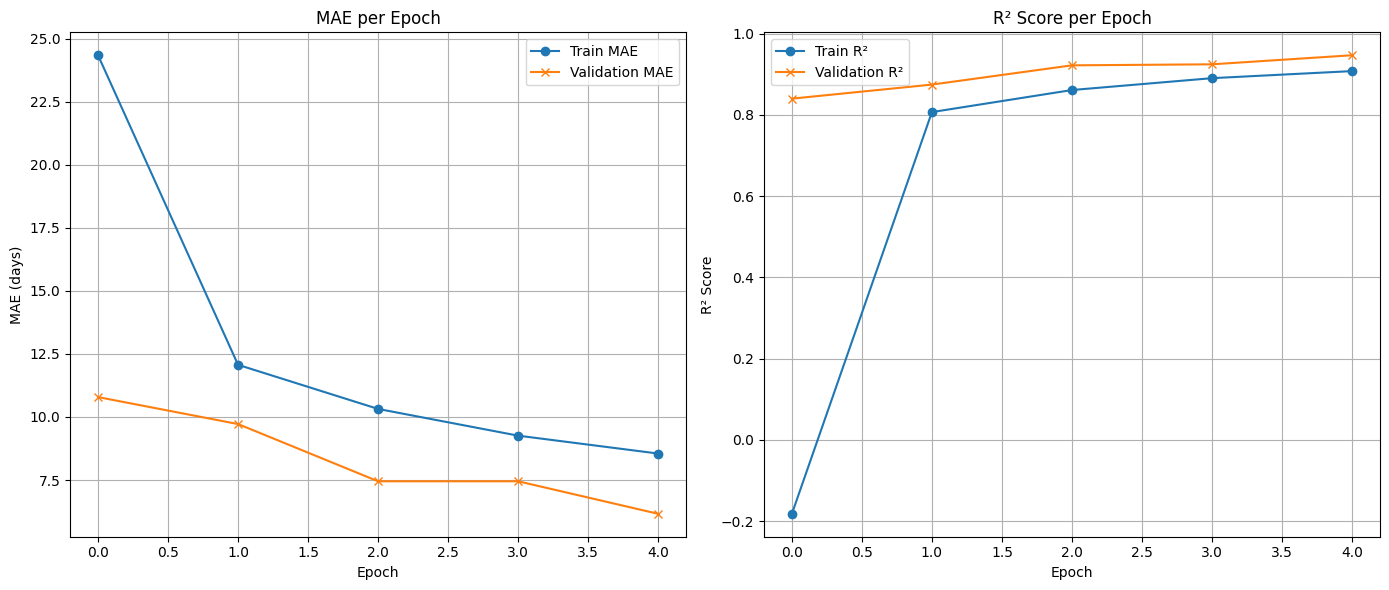

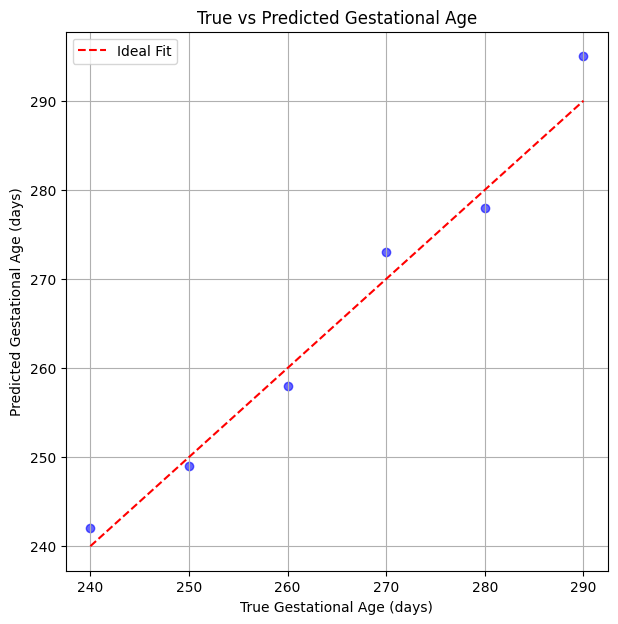

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy example (replace with your real arrays!)
# These must be lists of real numbers
y_true_val = [240, 250, 260, 270, 280, 290]  # True GA labels (example)
y_pred_val = [242, 249, 258, 273, 278, 295]  # Predicted GA (example)

train_mae_list = [24.35, 12.07, 10.32, 9.26, 8.55]
val_mae_list = [10.79, 9.72, 7.45, 7.45, 6.16]
train_r2_list = [-0.1822, 0.8068, 0.8611, 0.8903, 0.9077]
val_r2_list = [0.8399, 0.8745, 0.9219, 0.9244, 0.9467]

# ========================
# Plot MAE and R2 curves
# ========================
plt.figure(figsize=(14, 6))

# MAE
plt.subplot(1, 2, 1)
plt.plot(train_mae_list, label="Train MAE", marker='o')
plt.plot(val_mae_list, label="Validation MAE", marker='x')
plt.xlabel("Epoch")
plt.ylabel("MAE (days)")
plt.title("MAE per Epoch")
plt.legend()
plt.grid(True)

# R2
plt.subplot(1, 2, 2)
plt.plot(train_r2_list, label="Train R²", marker='o')
plt.plot(val_r2_list, label="Validation R²", marker='x')
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² Score per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ========================
# Scatter Plot True vs Pred
# ========================
plt.figure(figsize=(7, 7))
plt.scatter(y_true_val, y_pred_val, alpha=0.6, color='blue')
plt.plot([min(y_true_val), max(y_true_val)], [min(y_true_val), max(y_true_val)], 'r--', label="Ideal Fit")
plt.xlabel("True Gestational Age (days)")
plt.ylabel("Predicted Gestational Age (days)")
plt.title("True vs Predicted Gestational Age")
plt.legend()
plt.grid(True)
plt.show()
